# Spike Count Analyses

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import convolve

More **Pandas**: 
  - `df.groupby("spike_trial")`: This method groups the DataFrame using the "spike_trial" column, where rows with the same "spike_trial" value are bundled together as a single group (i.e. a dataframe). This is particularly useful when you want to perform some operation on each of these groups separately, like summing, averaging, or applying any custom function.
  - `df.groupby(["spike_trial", "spike_cell"])`: Here, the DataFrame is grouped by two columns: "spike_trial" and "spike_cell", where rows with the same "spike_trial" and "spike_cell" value combination are bundled together as a single group (i.e. a dataframe).
  - `df.apply(func)`: Apply a function `func` along the axis of the DataFrame.
  - `df.groupby("spike_trial").apply(func)`: After grouping by "spike_trial," this applies a function func to each group. For instance, using func = len would give the number of rows in each group.
  - `df.groupby("spike_trial").apply(func).reset_index(name="spike_count")`: After grouping and applying the function, reset the index and rename the resulting column to "spike_count".
  - `df[df.spike_time > df.stimulus_onset]`: Filter rows where the "spike_time" is greater than "stimulus_onset".
  - `df[(df.spike_time > df.stimulus_onset) & (df.spike_time < df.response_time)]`: Filter rows based on multiple conditions: where "spike_time" is greater than "stimulus_onset" and less than "response_time".

In [2]:
dset = xr.load_dataset("../../data/steinmetz_2016-12-14_Cori.nc")

cols = ['spike_trial', 'spike_cell', 'spike_time']
spike_time_df = dset[cols].to_dataframe().reset_index()
spike_time_df

,spike_id,spike_trial,spike_cell,spike_time
0,1,21,1,0.267635
1,2,21,1,2.308335
2,3,31,1,0.853476
3,4,37,1,2.197501
4,5,43,1,2.452692
...,...,...,...,...
2446168,2446169,364,734,0.266459
2446169,2446170,364,734,0.587060
2446170,2446171,364,734,0.618560
2446171,2446172,364,734,2.188634


##### Get the spike count for each trial.

In [3]:
spike_time_df.groupby(["spike_trial", "spike_cell"]).apply(len).reset_index(name="spike_count")

,spike_trial,spike_cell,spike_count
0,1,2,1
1,1,8,3
2,1,13,5
3,1,14,28
4,1,15,1
...,...,...,...
191557,364,729,4
191558,364,730,62
191559,364,731,9
191560,364,732,1


##### Get the spike count after stimulus onset.

In [4]:
spike_time_df["stimulus_onset"] = .5
dd = spike_time_df[spike_time_df.spike_time > spike_time_df.stimulus_onset]
dd.groupby(["spike_trial", "spike_cell"]).apply(len).reset_index(name="spike_count")

,spike_trial,spike_cell,spike_count
0,1,2,1
1,1,8,3
2,1,13,5
3,1,14,21
4,1,15,1
...,...,...,...
182205,364,726,3
182206,364,729,3
182207,364,730,47
182208,364,731,5


##### Get the spike count before response time.

In [5]:
# load the relevant variables
cols = ["response_time", "feedback_time", "gocue", "active_trials"]
experimental_df = dset[cols].to_dataframe().reset_index()
experimental_df = experimental_df[experimental_df.active_trials]

# Merge with the spike time dataframe
experimental_df = experimental_df.rename(columns={"trial": "spike_trial"})
spike_time_df = spike_time_df.merge(experimental_df)
spike_time_df

,spike_id,spike_trial,spike_cell,spike_time,stimulus_onset,response_time,feedback_time,gocue,active_trials
0,1,21,1,0.267635,0.5,2.555003,2.585641,1.049217,True
1,2,21,1,2.308335,0.5,2.555003,2.585641,1.049217,True
2,308,21,2,0.222801,0.5,2.555003,2.585641,1.049217,True
3,309,21,2,0.595668,0.5,2.555003,2.585641,1.049217,True
4,3421,21,7,0.291835,0.5,2.555003,2.585641,1.049217,True
...,...,...,...,...,...,...,...,...,...
1384064,2426915,155,730,2.463472,0.5,2.218932,2.253236,0.714011,True
1384065,2426916,155,730,2.470539,0.5,2.218932,2.253236,0.714011,True
1384066,2444511,155,732,2.176738,0.5,2.218932,2.253236,0.714011,True
1384067,2444512,155,732,2.186038,0.5,2.218932,2.253236,0.714011,True


In [6]:
dd = spike_time_df[spike_time_df.spike_time < spike_time_df.response_time]
dd.groupby(["spike_trial", "spike_cell"]).apply(len).reset_index(name="spike_count")

,spike_trial,spike_cell,spike_count
0,1,8,1
1,1,13,3
2,1,14,12
3,1,15,1
4,1,16,1
...,...,...,...
97661,214,728,2
97662,214,729,1
97663,214,730,47
97664,214,731,6


##### Get the spike count between stimulus onset and response time.

In [7]:
condition = (spike_time_df.spike_time > spike_time_df.stimulus_onset) & (spike_time_df.spike_time < spike_time_df.response_time)
dd = spike_time_df[condition]
dd.groupby(["spike_trial", "spike_cell"]).apply(len).reset_index(name="spike_count")

,spike_trial,spike_cell,spike_count
0,1,8,1
1,1,13,3
2,1,14,5
3,1,15,1
4,1,18,6
...,...,...,...
85486,214,727,3
85487,214,728,2
85488,214,729,1
85489,214,730,33


##### Get the spike count between response time and feedback time.

In [8]:
condition = (spike_time_df.spike_time > spike_time_df.response_time) & (spike_time_df.spike_time < spike_time_df.feedback_time)
dd = spike_time_df[condition]
dd.groupby(["spike_trial", "spike_cell"]).apply(len).reset_index(name="spike_count")

,spike_trial,spike_cell,spike_count
0,1,14,1
1,1,18,3
2,1,36,1
3,1,43,1
4,1,59,1
...,...,...,...
11114,214,374,1
11115,214,507,1
11116,214,599,1
11117,214,658,1


## Joint analysis of spike count and categorical variables (e.g. brain areas, correct/wrong trials)

In [9]:
dset = xr.load_dataset("../../data/steinmetz_2016-12-14_Cori.nc")

cols = ['spike_trial', 'spike_cell', 'spike_time']
spike_times_df = dset[cols].to_dataframe().reset_index()

brain_region_df = dset["brain_area"].to_dataframe().reset_index()
brain_region_df = brain_region_df.rename(columns={"cell": "spike_cell"})

df = pd.merge(spike_times_df, brain_region_df)
df

,spike_id,spike_trial,spike_cell,spike_time,brain_area
0,1,21,1,0.267635,ACA
1,2,21,1,2.308335,ACA
2,3,31,1,0.853476,ACA
3,4,37,1,2.197501,ACA
4,5,43,1,2.452692,ACA
...,...,...,...,...,...
2446168,2446169,364,734,0.266459,DG
2446169,2446170,364,734,0.587060,DG
2446170,2446171,364,734,0.618560,DG
2446171,2446172,364,734,2.188634,DG


##### Create a strip plot to show the distribution of population spike counts for each brain region across all trials

<Axes: xlabel='brain_area', ylabel='population_spike_count'>

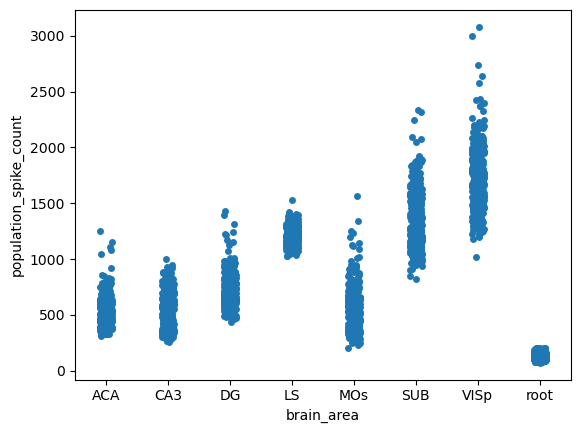

In [10]:
pop_spike_count_df = df.groupby(["spike_trial", "brain_area"]).apply(len).reset_index(name="population_spike_count")
sns.stripplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count")

##### Create a boxen plot for the same data

<Axes: xlabel='brain_area', ylabel='population_spike_count'>

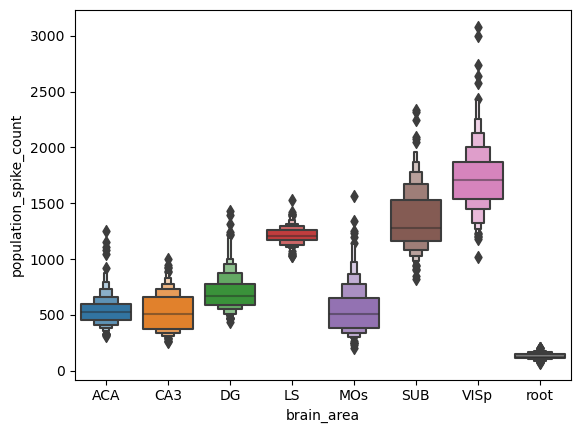

In [11]:
sns.boxenplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count")

##### Overlay the strip plot and the boxen plot in the same plot.

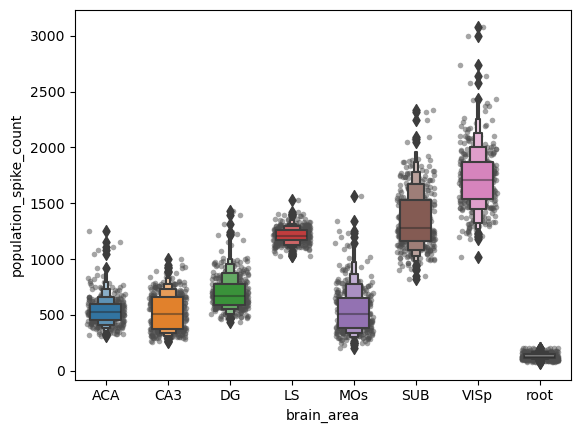

In [12]:
sns.stripplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", size=4, color=".3", alpha=.5, jitter=.3, zorder=0)
ax = sns.boxenplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", width=.5)

##### Does the distribution change when conditioned on correct vs wrong trials?

In [13]:
cols = ["active_trials", "feedback_type"]
active_trials_df = dset[cols].to_dataframe().reset_index()
active_trials_df = active_trials_df.rename(columns={"trial": "spike_trial"})
pop_spike_count_df = pop_spike_count_df.merge(active_trials_df)
pop_spike_count_df = pop_spike_count_df[pop_spike_count_df.active_trials]
pop_spike_count_df

,spike_trial,brain_area,population_spike_count,active_trials,feedback_type
0,1,ACA,676,True,1.0
1,1,CA3,754,True,1.0
2,1,DG,566,True,1.0
3,1,LS,1185,True,1.0
4,1,MOs,455,True,1.0
...,...,...,...,...,...
1707,214,LS,1267,True,-1.0
1708,214,MOs,538,True,-1.0
1709,214,SUB,1377,True,-1.0
1710,214,VISp,1845,True,-1.0


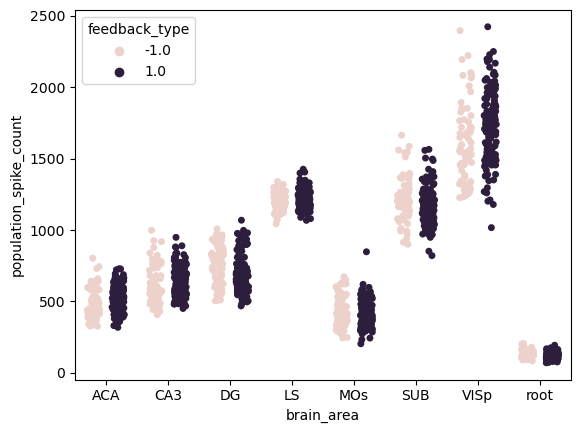

In [14]:
sns.stripplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", dodge=True, jitter=.2);

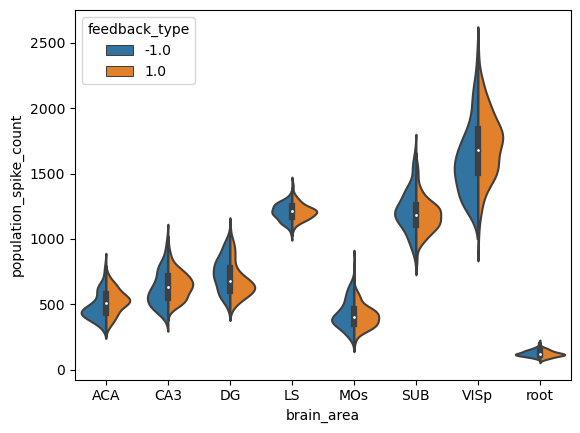

In [15]:
sns.violinplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", split=True);

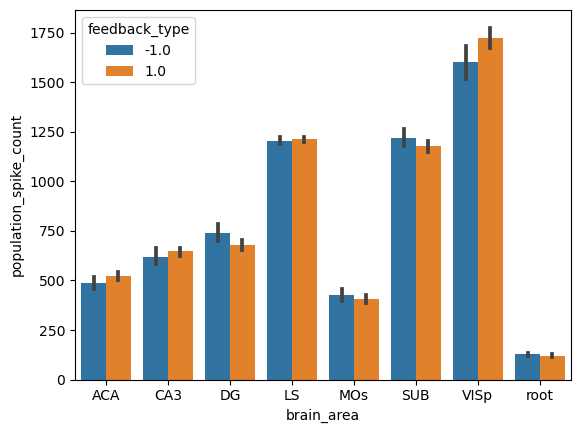

In [16]:
sns.barplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", errorbar=('ci', 99));

##### How does the result change when looking at area groups?

In [17]:
cols = ["brain_area", "brain_groups"]
brain_area_groups_df = dset[cols].to_dataframe().drop_duplicates().reset_index(drop=True)
pop_spike_count_df = pop_spike_count_df.merge(brain_area_groups_df)

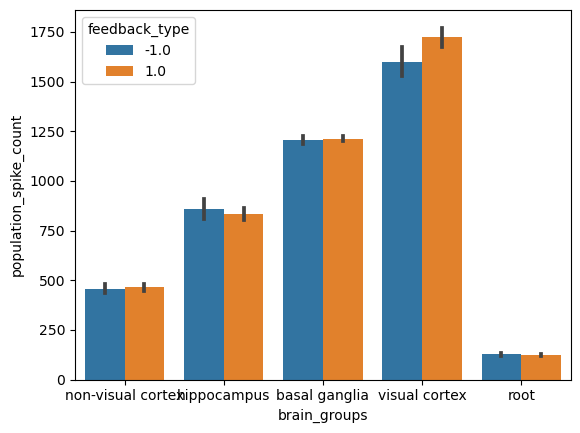

In [18]:
sns.barplot(data=pop_spike_count_df, x="brain_groups", y="population_spike_count", hue="feedback_type", errorbar=("ci", 99));

##### Create a figure with two panels where one panels shows the distribution of spikes across multiple areas for when the mouse was rewarded, and the other panel when the mouse was not rewarded.

##### Save the figure as a pdf file

## Advance plotting with Matplotlib and Seaborn